In [47]:
___Author___='LumberJack Jyss'

In [48]:
print('Global Optimized LumberJack Equities Method\n°OoO_FOREX_Oo0°\nLumberJack Jyss 5779(c)')

Global Optimized LumberJack Equities Method
°OoO_FOREX_Oo0°
LumberJack Jyss 5779(c)


In [49]:
print('Importing librairies...')
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,roc_curve
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%matplotlib inline
print('Librairies imported')

Importing librairies...
Librairies imported


In [50]:
import warnings
warnings.filterwarnings("ignore")
tf.logging.set_verbosity(tf.logging.ERROR)

In [51]:
df_15min= pd.read_csv('20190526 data prepared.csv')
df_15min = df_15min.iloc[:,1:]
df_15min = df_15min.dropna()
df_15min.reset_index(inplace=True,drop=True)

plt.figure(figsize=(26,20))
sns.heatmap(df_15min.iloc[:,:-1].corr(),annot=True,cmap='rainbow')
plt.show()

In [52]:
df_15min['target_up'].sum(),df_15min['target_down'].sum()

(59, 59)

In [53]:
delta = round(df_15min.shape[0])
bloc1 = round(delta*0.8)
bloc2 = delta - bloc1
print("# of periods : ",delta)
print('On 80% - 20% slash : ')
print('Bloc 1 : ',bloc1,' periods (',df_15min.iloc[bloc1,0],')\nBloc 2 :',bloc2,' periods (',df_15min.iloc[bloc2,0],')')
print('First period :',df_15min.iloc[0,0])
print('Last period :',df_15min.iloc[df_15min.shape[0]-1,0])


# of periods :  6441
On 80% - 20% slash : 
Bloc 1 :  5153  periods ( 20190321  17:30:00 )
Bloc 2 : 1288  periods ( 20180814  21:15:00 )
First period : 20180604  21:15:00
Last period : 20190531  21:45:00


In [54]:
X = df_15min.iloc[:,1:-4]

y_up = df_15min.iloc[:,-3].values
y_down = df_15min.iloc[:,-2].values

In [55]:
ytrain_up = y_up[:bloc1]
ytest_up = y_up[bloc1:]
ytrain_down = y_down[:bloc1]
ytest_down = y_down[bloc1:]

In [56]:
Xtrain_up =   X.iloc[:bloc1,:] #X.loc[:bloc1-1,['Varop_Spy','delta40_45', 'delta45_50']]
Xtrain_down = X.iloc[:bloc1,:] #X.loc[:bloc1-1,['Varop_Spy','75 - RSI', 'BBD_Delta_Up']]
Xtest_up =   X.iloc[bloc1:,:] #X.loc[bloc1:,['Varop_Spy','delta40_45', 'delta45_50']]
Xtest_down = X.iloc[bloc1:,:] #X.loc[bloc1:,['Varop_Spy','75 - RSI', 'BBD_Delta_Up']]

In [57]:
from collections import Counter
print('Original dataset shape_up %s' % Counter(y_up))
print('Original dataset shape_down %s' % Counter(y_down))

Original dataset shape_up Counter({0: 6382, 1: 59})
Original dataset shape_down Counter({0: 6382, 1: 59})


from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=42,sampling_strategy='not majority') 
Xtrain_up, ytrain_up = cc.fit_resample(Xtrain_up, ytrain_up)
Xtrain_down, ytrain_down = cc.fit_resample(Xtrain_down, ytrain_down)

In [58]:
print('Resampled dataset shape %s' % Counter(ytrain_up))
print('Resampled dataset shape %s' % Counter(ytrain_down))

Resampled dataset shape Counter({0: 5105, 1: 48})
Resampled dataset shape Counter({0: 5105, 1: 48})


In [59]:
scaler = MinMaxScaler(feature_range=(0, 1))
Xtrain_up = scaler.fit_transform(Xtrain_up)
Xtest_up = scaler.fit_transform(Xtest_up)
Xtrain_down = scaler.fit_transform(Xtrain_down)
Xtest_down = scaler.fit_transform(Xtest_down)


#y_up = scaler.fit_transform(np.array(y_up).reshape(-1,1))
#y_down = scaler.fit_transform(np.array(y_down).reshape(-1,1))
y_up = np.array(y_up).reshape(-1,1)
y_down = np.array(y_down).reshape(-1,1)

In [60]:
Xtest_up.shape,Xtrain_up.shape,Xtrain_down.shape,ytrain_up.shape,ytrain_down.shape,ytest_down.shape,ytest_up.shape

((1288, 16), (5153, 16), (5153, 16), (5153,), (5153,), (1288,), (1288,))

In [61]:
model_up = XGBClassifier(n_estimators=10,min_child_weight=0.2)
eval_set_up = [(Xtrain_up, ytrain_up), (Xtest_up, ytest_up)]
history_up = model_up.fit( Xtrain_up, ytrain_up, eval_metric=['auc','error'], eval_set=eval_set_up, verbose=0)
print ("Score Train -->", round(model_up.score(Xtest_up, ytest_up) *100,2), " %")


Score Train --> 97.98  %


In [62]:
model_down = XGBClassifier(n_estimators=10,min_child_weight=0.2)
eval_set_down = [(Xtrain_down, ytrain_down), (Xtest_down, ytest_down)]
history_down = model_down.fit( Xtrain_down, ytrain_down, eval_metric=['auc','error'], eval_set=eval_set_down, verbose=0)
print ("Score Train -->", round(model_down.score(Xtest_down, ytest_down) *100,2), " %")

Score Train --> 99.15  %


In [63]:
yhat_up = model_up.predict(Xtest_up)
yhat_down = model_down.predict(Xtest_down)

accuracy_up = accuracy_score(ytest_up, yhat_up)
accuracy_down = accuracy_score(ytest_down, yhat_down)

# La précision permet de mesurer la capacité du modèle à refuser résultats non-pertinents : vrais_positifs/(vrais_positifs+faux_positifs)
precision_up = precision_score(ytest_up, yhat_up)  
precision_down = precision_score(ytest_down, yhat_down) 


# Recall : (vrai_positifs/(vrais_positifs+faux_négatifs))
recall_up = recall_score(ytest_up, yhat_up) 
recall_down = recall_score(ytest_down, yhat_down) 

f1_up = (2 * (precision_up * recall_up)) / (precision_up + recall_up)
f1_down = (2 * (precision_down * recall_down)) / (precision_down + recall_down)

roc_up=roc_auc_score(ytest_up,yhat_up)
roc_down=roc_auc_score(ytest_down,yhat_down)

In [64]:
sum(yhat_up),sum(yhat_down)

(17, 0)

In [65]:
print('RESULTATS UP\n')
print('Accuracy: %.2f%%' % (accuracy_up * 100.0))
print("Precision: %.2f%% " % (precision_up *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_up * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print('F1 : %.2f%%' % (f1_up * 100))
print("AUC: %.2f%% " % (roc_up *100))
# get probabilities for positive class

print(classification_report(ytest_up, yhat_up))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_up, yhat_up))
print('Matrice de confusion :')
conf_matrix

RESULTATS UP

Accuracy: 97.98%
Precision: 5.88%   => Discrimnination des vrais positifs parmi les faux positifs
Recall: 9.09%   => Positifs trouvés par Golem sur tous les positifs existants
F1 : 7.14%
AUC: 53.92% 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1277
           1       0.06      0.09      0.07        11

   micro avg       0.98      0.98      0.98      1288
   macro avg       0.53      0.54      0.53      1288
weighted avg       0.98      0.98      0.98      1288

[[1261   16]
 [  10    1]]
Matrice de confusion :


,Vrais_estimés,Faux_estimés
vrais_réels,Vrais_positifs,Faux_négatif
Faux_réels,Faux_positifs,Vrais-négatifs


In [66]:
print('RESULTATS DOWN\n')
print('Accuracy: %.2f%%' % (accuracy_down * 100.0))
print("Precision: %.2f%% " % (precision_down *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_down * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print('F1 : %.2f%%' % (f1_down * 100))
print("AUC: %.2f%% " % (roc_down *100))
# get probabilities for positive class

print(classification_report(ytest_down, yhat_down))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_down, yhat_down))
print('Matrice de confusion :')
conf_matrix

RESULTATS DOWN

Accuracy: 99.15%
Precision: 0.00%   => Discrimnination des vrais positifs parmi les faux positifs
Recall: 0.00%   => Positifs trouvés par Golem sur tous les positifs existants
F1 : nan%
AUC: 50.00% 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1277
           1       0.00      0.00      0.00        11

   micro avg       0.99      0.99      0.99      1288
   macro avg       0.50      0.50      0.50      1288
weighted avg       0.98      0.99      0.99      1288

[[1277    0]
 [  11    0]]
Matrice de confusion :


,Vrais_estimés,Faux_estimés
vrais_réels,Vrais_positifs,Faux_négatif
Faux_réels,Faux_positifs,Vrais-négatifs


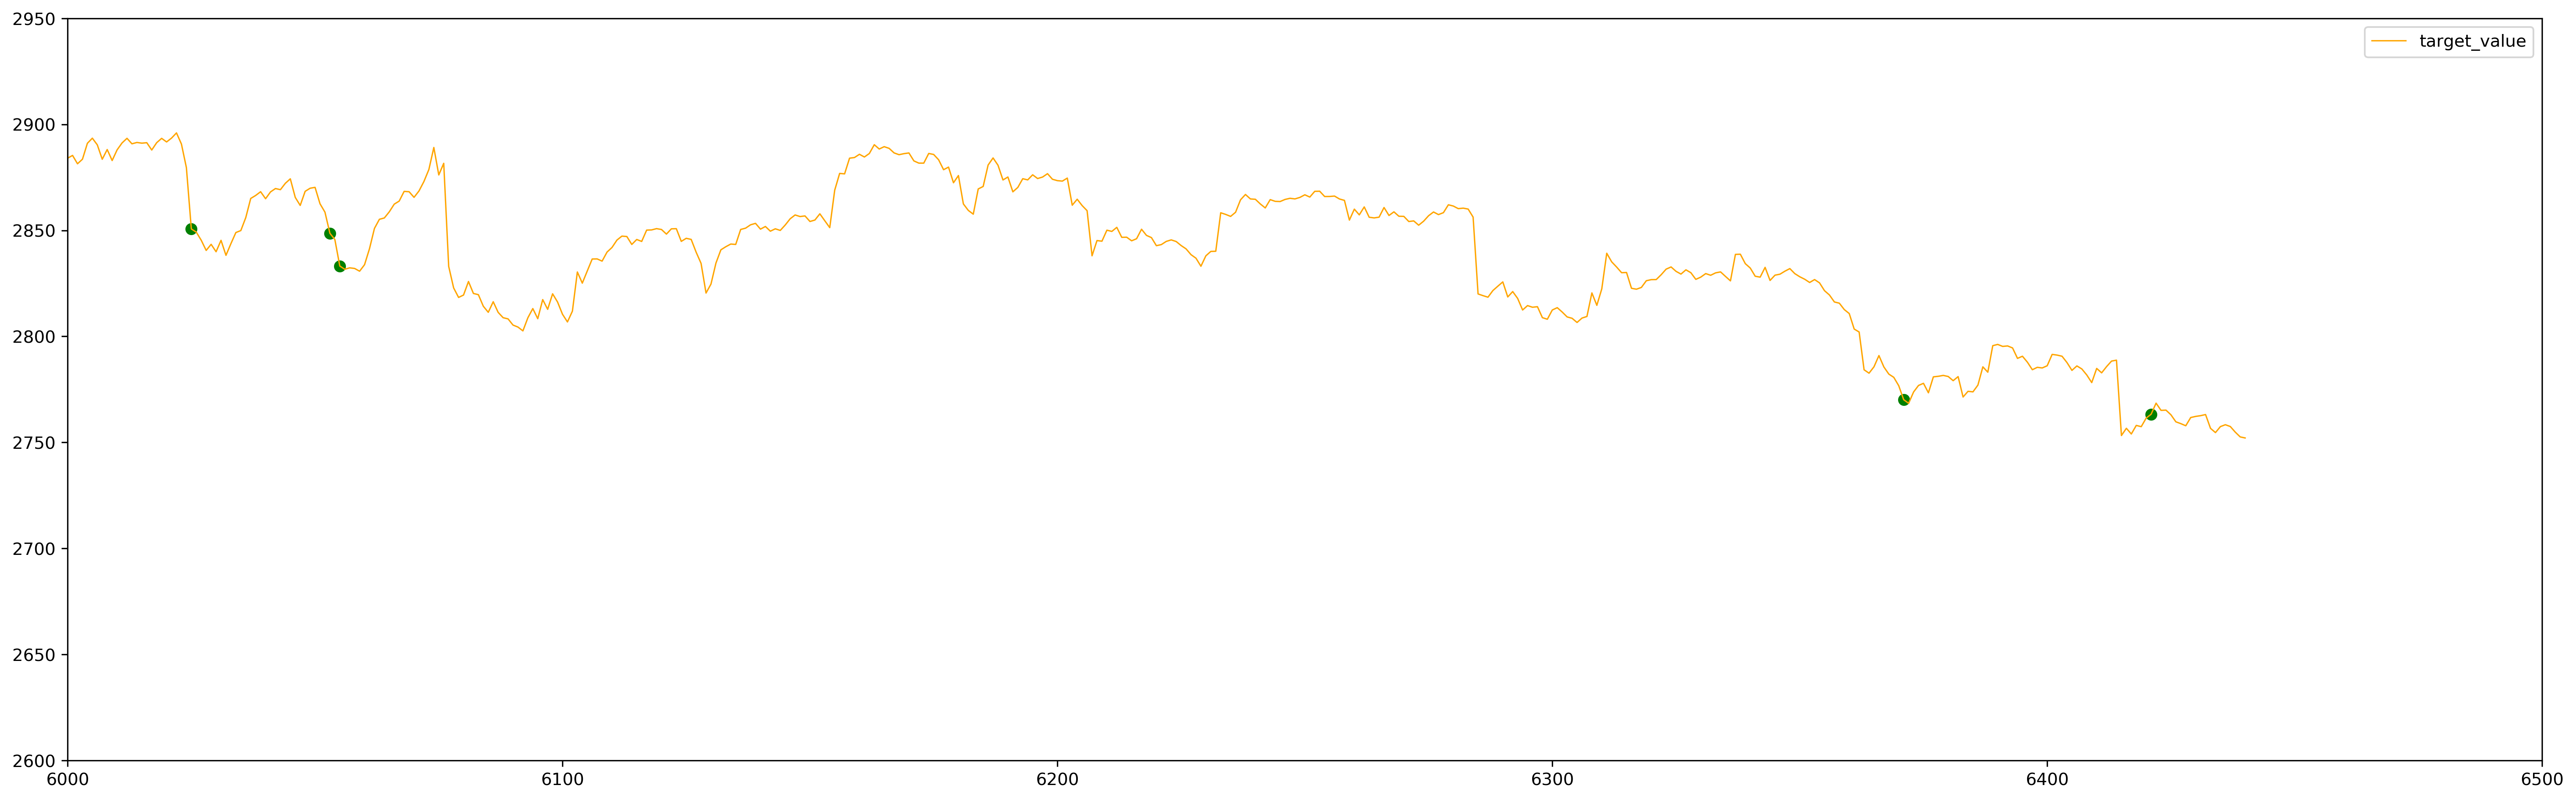

In [67]:
plt.figure(figsize=(26,8),dpi=300)
plt.plot(df_15min['target_value'],color='orange',lw=0.8)
plt.xlim(6000,6500)
plt.ylim(2600,2950)
a = -1
for i in range(len(df_15min)-bloc2,len(df_15min)):
    a+=1
    if yhat_up[a] == 1:
        plt.scatter(x=df_15min.index[i],y=df_15min.iloc[i,-1],c='g',marker='o')
    elif yhat_down[a] == 1:
        plt.scatter(x=df_15min.index[i],y=df_15min.iloc[i,-1],c='r',marker='o')
plt.legend()

In [68]:
sum(yhat_up),sum(yhat_down)

(17, 0)

In [69]:
# save the model to disk
filename = 'finalized_model_long.sav'
pickle.dump(model_up, open(filename, 'wb'))
filename = 'finalized_model_short.sav'
pickle.dump(model_down, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)